# Este programa faz a preparacao dos dados para executar a previsão 
# de vacinados no Banco Dados coletado da APIs Vacina do site gov.br:

## Desse Banco de Dados, foi gerado uma Amostra randomicamente,
## definindo uma porcentage de 0.001 ==> 1 em cada 1.000

In [ ]:
# DATA ; 17/5/2021

In [1]:
import csv
import time
import requests 
import pandas  as pd
import seaborn as sns
from random   import random
from prophet  import Prophet
from datetime import datetime
from datetime import date


# Importar bibliotecas para construir gráficos:

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Bibliotecas de Algoritmos de Regressão:
from sklearn.tree            import DecisionTreeClassifier
from catboost                import CatBoostClassifier
from sklearn.metrics         import accuracy_score
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing   import StandardScaler
from sklearn.ensemble        import RandomForestRegressor, ExtraTreesRegressor


# Biblioteca do Prophet para Algoritmo de Previsão:

from prophet      import Prophet
from prophet.plot import plot_plotly
from prophet.plot import plot_components_plotly

df = pd.read_csv("BD_Amostra-Alguns-12-05-2021.csv", sep=";")
usecols   = ['vacina_fabricante_nome',
             'paciente_idade',
             'paciente_id',
             'vacina_dataAplicacao',
             'paciente_endereco_uf',
             'vacina_descricao_dose']

# Leitura do mesmo Banco Dados da Amostra no dia 12/05/2021:



In [12]:
# Denindo as Variaveis Globais:

FATOR_AMOSTRA = 0.001 # 1/1000

In [ ]:
# Trabalhando com arquivo de Amostra, usarei algumas colunas
# relevantes para tratar com a Previsao Vacinados.

## Leitura BD_Amostra do dia 12/05/2021:
## DataFrame conterá as colunas dos vacinados 1.Dose e 2. Dose

In [ ]:
# Primeiro passo: cuidar do campo 'vacina_dataAplicacao' para ter somente a DATA

In [5]:
# Preparando o campo para o datetime: formato = %Y-%m-%dT%H:%M:%S"


In [2]:
df['vacina_dataAplicacao']

0        2021-02-06T00:00:00.000Z
1        2021-03-06T00:00:00.000Z
2        2021-04-13T00:00:00.000Z
3        2021-03-30T00:00:00.000Z
4        2021-03-17T00:00:00.000Z
                   ...           
50934    2021-05-12T00:00:00.000Z
50935    2021-05-11T00:00:00.000Z
50936    2021-05-03T00:00:00.000Z
50937    2021-04-01T00:00:00.000Z
50938    2021-05-11T00:00:00.000Z
Name: vacina_dataAplicacao, Length: 50939, dtype: object

In [ ]:
# Preciso tratar o campo 'vacina_dataAplicacao' :
# 1) aparecer o DD/MM/YY
# 2) remover o timezone

In [3]:
# converter a coluna datetime  somente em date

df['vacina_dataAplicacao'] = pd.to_datetime(df['vacina_dataAplicacao']).dt.date


df.dtypes


vacina_fabricante_nome    object
paciente_idade             int64
paciente_id               object
vacina_dataAplicacao      object
paciente_endereco_uf      object
vacina_descricao_dose     object
dtype: object

In [5]:
# Note que o cmpo 'vacina_dataAplicao' é tipo = object
# Preciso usar a função: normalize()  que será mostrado no campo date:
#  'vacina_dataAplicacao' tem que ser ==> datetime64 
# 

df['vacina_dataAplicao'] = pd.to_datetime(df['vacina_dataAplicacao']).dt.normalize()

# Vericando os tipos do DataFrame:
df.dtypes

vacina_fabricante_nome            object
paciente_idade                     int64
paciente_id                       object
vacina_dataAplicacao              object
paciente_endereco_uf              object
vacina_descricao_dose             object
vacina_dataAplicao        datetime64[ns]
dtype: object

In [4]:
df['vacina_dataAplicacao']

0        2021-02-06
1        2021-03-06
2        2021-04-13
3        2021-03-30
4        2021-03-17
            ...    
50934    2021-05-12
50935    2021-05-11
50936    2021-05-03
50937    2021-04-01
50938    2021-05-11
Name: vacina_dataAplicacao, Length: 50939, dtype: object

In [2]:
# Segundo Passo: tratando do campo "vacina_descricao_dose"

In [ ]:
# Para a aplicação da Vacina se:
#   Primeira Dose 
#   Segunda Dose após um intervalo definido

In [5]:
df["vacina_descricao_dose"].unique()


array(['\xa0\xa0\xa0\xa01ª\xa0Dose', '\xa0\xa0\xa0\xa02ª\xa0Dose',
       '1ª Dose', '2ª Dose', 'Única'], dtype=object)

In [65]:
# Note que no campo contém a seguinte descrição:

# array(['\xa0\xa0\xa0\xa01ª\xa0Dose', 
#        '\xa0\xa0\xa0\xa02ª\xa0Dose']
#        '1ª Dose', '2ª Dose', 'Única'



In [6]:
# Fazendo uma limpeza do campo "vacina_descricao_dose" 
# nos dois DataFrames:

# 1) Transformando todos as linhas como Minuúsculas
# 2) Quando aparecer Null (NaN) substitui-se por "-"
# 3) Tratando todos os caracteres ASCII 

df["vacina_descricao_dose"] = (df["vacina_descricao_dose"]
                                 .str.lower()
                                 .str.normalize("NFKD")
                                 .str.lstrip()
                                 .str.replace(" ","_")
                                 .str.encode("ascii", errors="ignore")
                                 .str.decode("utf-8"))

# Mineirando os Dados:

# Vou tratar o campo 'vacina_descricao_dose':

## Teremos 3 situações para contabilizar o número de vacinas tomadas:
##  (1) A Primeira Dose ==> 1a_dose
##  (2) A Segunda Dose  ==> Totalmente vacinados com a  2a_dose
##  (3) Ser Dose Unica!!

In [7]:
df["vacina_descricao_dose"].value_counts



<bound method IndexOpsMixin.value_counts of 0        1a_dose
1        2a_dose
2        1a_dose
3        1a_dose
4        2a_dose
          ...   
50934    1a_dose
50935    2a_dose
50936    2a_dose
50937    1a_dose
50938    1a_dose
Name: vacina_descricao_dose, Length: 50939, dtype: object>

# Usando Get_Dummies para descrever as 


In [8]:

dummies = df["vacina_descricao_dose"].str.get_dummies("\n")


In [9]:
# Concatenar com o DataFrame e a coluna já tratada como 1. Dose :

df = pd.concat([df, dummies], axis = 1)

In [10]:
dummies.head(5)

,1a_dose,2a_dose,unica
0,1,0,0
1,0,1,0
2,1,0,0
3,1,0,0
4,0,1,0


In [13]:
Vacinados_uma_dose = df['1a_dose'].sum()


print('Vacinados com 1. dose = ', Vacinados_uma_dose/FATOR_AMOSTRA)

Vacinados com 1. dose =  34874000.0


In [14]:
Vacinados_duas_doses = df['2a_dose'].sum()


print('Vacinados com 2. dose = ', Vacinados_duas_doses/FATOR_AMOSTRA)

Vacinados com 2. dose =  16064000.0


In [15]:
# Limpando os campos das Doses, retirando os nulos NaN

df['1a_dose'].fillna(0, inplace = True)

df['2a_dose'].fillna(0, inplace = True)

df['unica'].fillna(0, inplace = True)


<AxesSubplot:xlabel='count', ylabel='vacina_descricao_dose'>

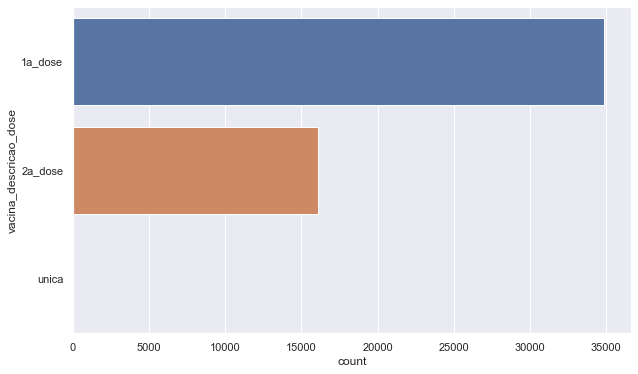

In [16]:
plt.figure(figsize = (10,6))
sns.countplot(data = df, y = "vacina_descricao_dose")

# Trabalhando com informações da 1a_dose para rodar a PREVISAO:

In [17]:
df1 = df.groupby('vacina_dataAplicacao').agg({'1a_dose':'sum'}).reset_index()

df1['vacina_dataAplicacao'].value_counts()


2021-01-19    1
2021-02-03    1
2021-03-30    1
2021-04-09    1
2021-03-27    1
             ..
2021-02-12    1
2021-03-01    1
2021-04-28    1
2021-04-25    1
2021-04-02    1
Name: vacina_dataAplicacao, Length: 115, dtype: int64

In [18]:
df1.head(3)

,vacina_dataAplicacao,1a_dose
0,2021-01-18,2
1,2021-01-19,64
2,2021-01-20,297


# Terceiro Passo: 
# Usar o Algoritmo do Prophets do Facebook para Previsao:

## ds = 'vacina_dataAplicacao' 
## ds é a coluna de carimbo de data e deve ser conforme o formato de 
## data / hora do pandas , AAAA-MM-DD


## A coluna y = deve ser numérica e representa a medida que desejamos prever
## y = total da 1. dose para dataframe == df1 ou 2.dose para dataframe == df2

In [17]:
df1.columns = ['ds', 'y']

In [18]:
df1.head(3)

,ds,y
0,2021-01-18,2
1,2021-01-19,64
2,2021-01-20,297


In [20]:
df1.ds.max()

datetime.date(2021, 5, 12)

# Prepara o Modelo Prophet() e aplica método fit() para '1a_dose'

In [21]:
# DataFrame df_prophet usará o DataFrame df1 que contém informações da '1a_dose'
# Configurando os parâmetros para não mostrar a mensagem de INFO:
#  yearly_seasonality = True
#  daily_seasonalit y= True

df_prophet = Prophet(yearly_seasonality=True, daily_seasonality=True)

df_prophet.fit(df1)

future = df_prophet.make_future_dataframe(periods = 180, include_history=False)


In [22]:
future.head(5)

,ds
0,2021-05-13
1,2021-05-14
2,2021-05-15
3,2021-05-16
4,2021-05-17


In [23]:
future.min()

ds   2021-05-13
dtype: datetime64[ns]

In [24]:
future.max()

ds   2021-11-08
dtype: datetime64[ns]

In [28]:
# Verificando as previsões:

valores_futuro = df_prophet.predict(future)

valores_futuro

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-05-13,82.851364,-32.859800,269.146517,82.851363,82.851364,32.554471,32.554471,32.554471,128.155688,...,65.536540,65.536540,65.536540,-161.137756,-161.137756,-161.137756,0.0,0.0,0.0,115.405835
1,2021-05-14,83.275995,-81.197169,217.156942,83.275976,83.276009,-15.245712,-15.245712,-15.245712,128.155688,...,51.299294,51.299294,51.299294,-194.700694,-194.700694,-194.700694,0.0,0.0,0.0,68.030284
2,2021-05-15,83.700627,-242.830807,57.012135,83.700580,83.700668,-176.711681,-176.711681,-176.711681,128.155688,...,-77.694885,-77.694885,-77.694885,-227.172483,-227.172483,-227.172483,0.0,0.0,0.0,-93.011054
3,2021-05-16,84.125259,-444.372009,-147.010444,84.125169,84.125330,-382.467859,-382.467859,-382.467859,128.155688,...,-252.825942,-252.825942,-252.825942,-257.797605,-257.797605,-257.797605,0.0,0.0,0.0,-298.342600
4,2021-05-17,84.549891,-151.850809,142.413529,84.549752,84.550010,-83.693985,-83.693985,-83.693985,128.155688,...,73.988328,73.988328,73.988328,-285.838001,-285.838001,-285.838001,0.0,0.0,0.0,0.855905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,2021-11-04,157.161914,317.866029,628.060600,157.128191,157.198476,320.095939,320.095939,320.095939,128.155688,...,65.536540,65.536540,65.536540,126.403712,126.403712,126.403712,0.0,0.0,0.0,477.257853
176,2021-11-05,157.586546,323.296885,624.040765,157.552619,157.623259,312.982412,312.982412,312.982412,128.155688,...,51.299294,51.299294,51.299294,133.527430,133.527430,133.527430,0.0,0.0,0.0,470.568958
177,2021-11-06,158.011178,200.441470,495.782651,157.977044,158.048068,186.755413,186.755413,186.755413,128.155688,...,-77.694885,-77.694885,-77.694885,136.294611,136.294611,136.294611,0.0,0.0,0.0,344.766591
178,2021-11-07,158.435809,23.815103,321.931723,158.401469,158.472972,9.909016,9.909016,9.909016,128.155688,...,-252.825942,-252.825942,-252.825942,134.579270,134.579270,134.579270,0.0,0.0,0.0,168.344825


# Note que  o dataframe resultante: valores_futuro, contém muitas informações, possuindo 16 colunas. 
# Precisamos das colunas: ds(data) e das colunas: yhat, yhat_lower, yhat_upper 
# que se referem à previsão obtida pelo prophet.



In [44]:
valores_futuro[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
175,2021-11-04,477.257853,343.415633,636.310969
176,2021-11-05,470.568958,323.821986,629.436192
177,2021-11-06,344.766591,194.495275,491.608532
178,2021-11-07,168.344825,19.784676,328.094938
179,2021-11-08,489.389012,342.510304,628.983686


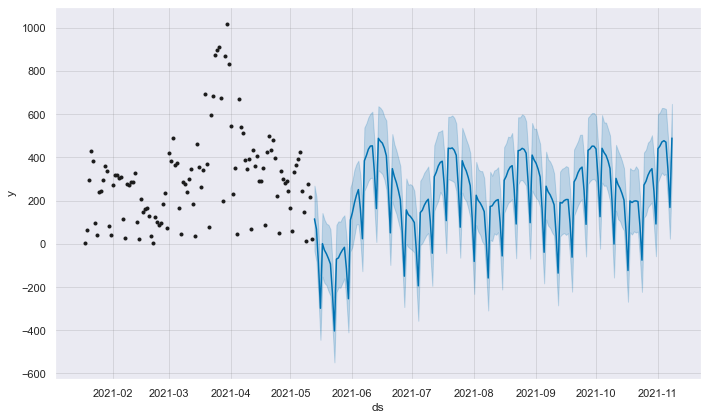

In [29]:
figl = df_prophet.plot(valores_futuro)



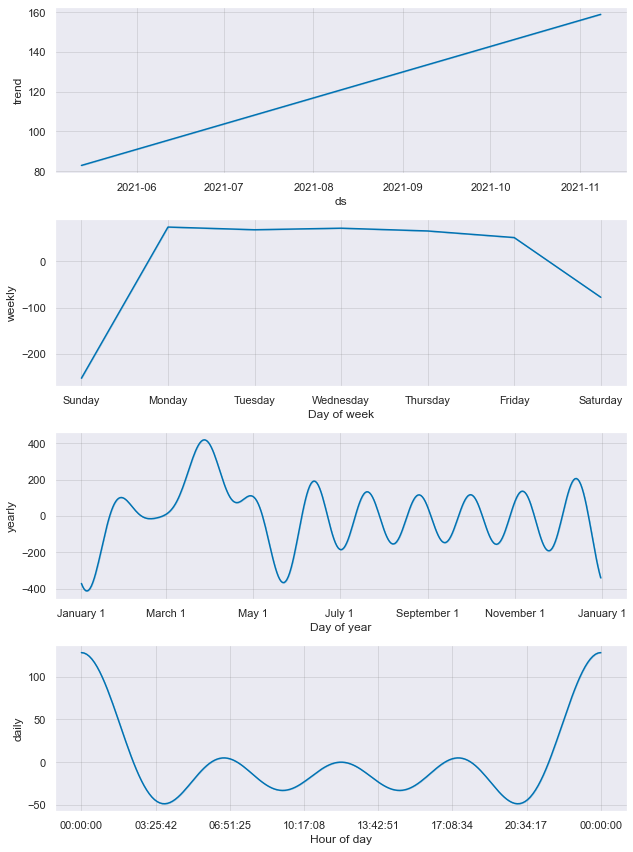

In [48]:
fig2 = df_prophet.plot_components(valores_futuro)

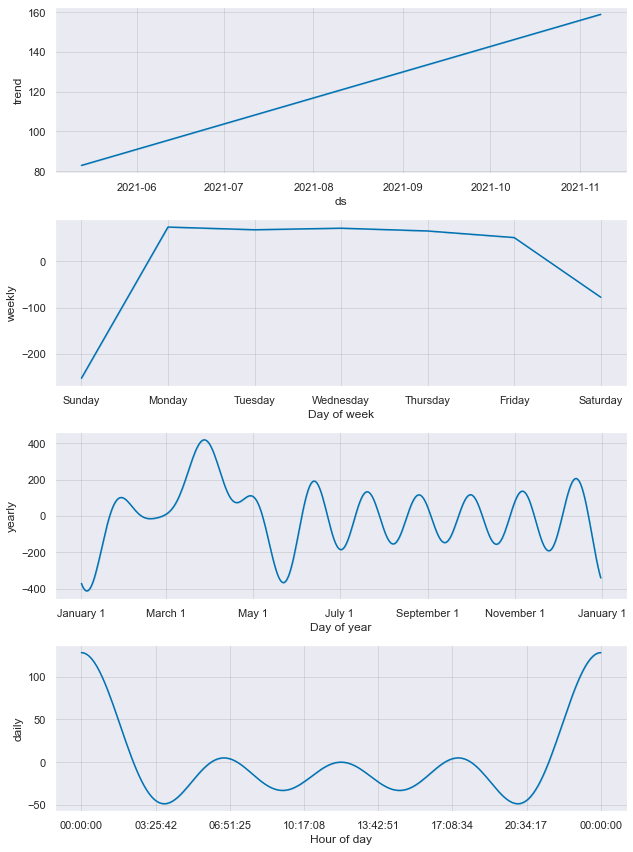

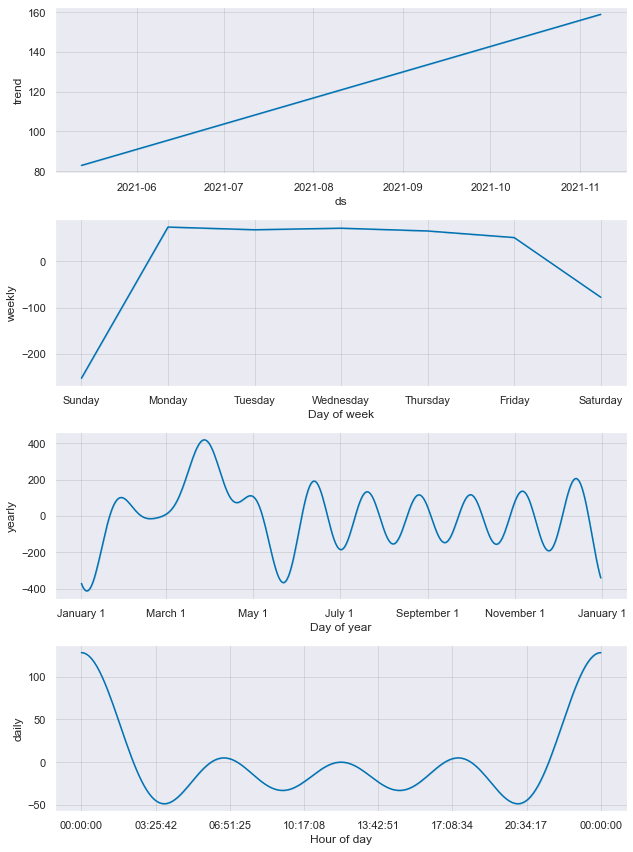

In [30]:
# Usando plot_components() serão apresentados quatro tipos de gráficos:
#     - trend line
#     - yearly seasonality
#     - weekly seasonality
#     - daily seasonality

df_prophet.plot_components(valores_futuro)

# Rodando o Algorítmo de Previsao PROPHETS para '2a_dose'

In [19]:
df2 = df.groupby('vacina_dataAplicacao').agg({'2a_dose':'sum'}).reset_index()

df2['vacina_dataAplicacao'].value_counts()


2021-01-19    1
2021-02-03    1
2021-03-30    1
2021-04-09    1
2021-03-27    1
             ..
2021-02-12    1
2021-03-01    1
2021-04-28    1
2021-04-25    1
2021-04-02    1
Name: vacina_dataAplicacao, Length: 115, dtype: int64

In [27]:
df2.head(3)

,ds,y
0,2021-01-18,0
1,2021-01-19,0
2,2021-01-20,0


In [ ]:
# Neste ponto é NECESARIO reset no codigo para executar o PROPHETS

# Prepara o Modelo Prophet() e aplica método fit() para '2a_dose'

In [22]:
# Preciso definir as colunas 'ds' e 'y' do DataFrame '2a_dose'

# Nesse ponto é muito importante, pois quem foi vacinado com a 2a_dose'
# já está tomalmente imunizado!!!!

df2.columns = ['ds', 'y']

In [28]:
df2

,ds,y
0,2021-01-18,0
1,2021-01-19,0
2,2021-01-20,0
3,2021-01-21,1
4,2021-01-22,2
...,...,...
110,2021-05-08,53
111,2021-05-09,10
112,2021-05-10,129
113,2021-05-11,138


In [30]:
# DataFrame df_prophet usará o DataFrame df2 agora, que contém informações da '2a_dose'
# Configurando os parâmetros para não mostrar a mensagem de INFO:
#  yearly_seasonality = True
#  daily_seasonalit y= True

df_prophet_2 = Prophet(yearly_seasonality=True, daily_seasonality=True)

df_prophet_2.fit(df2)

future_2 = df_prophet.make_future_dataframe(periods = 180, include_history=False)


In [31]:
future_2

,ds
0,2021-05-13
1,2021-05-14
2,2021-05-15
3,2021-05-16
4,2021-05-17
...,...
175,2021-11-04
176,2021-11-05
177,2021-11-06
178,2021-11-07


In [32]:
# Verificando as previsões:

valores_futuro_2 = df_prophet.predict(future_2)

valores_futuro_2

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-05-13,56.679438,-3.104423,189.153370,56.679438,56.679438,37.571207,37.571207,37.571207,80.271834,...,53.517733,53.517733,53.517733,-96.218360,-96.218360,-96.218360,0.0,0.0,0.0,94.250646
1,2021-05-14,56.997878,-15.642001,174.674698,56.997878,56.997879,27.970034,27.970034,27.970034,80.271834,...,40.044512,40.044512,40.044512,-92.346312,-92.346312,-92.346312,0.0,0.0,0.0,84.967912
2,2021-05-15,57.316319,-112.795163,65.002322,57.316317,57.316320,-79.747618,-79.747618,-79.747618,80.271834,...,-74.579322,-74.579322,-74.579322,-85.440130,-85.440130,-85.440130,0.0,0.0,0.0,-22.431299
3,2021-05-16,57.634759,-156.945097,32.431757,57.634756,57.634762,-121.304200,-121.304200,-121.304200,80.271834,...,-125.811791,-125.811791,-125.811791,-75.764243,-75.764243,-75.764243,0.0,0.0,0.0,-63.669441
4,2021-05-17,57.953199,29.159607,221.603094,57.953195,57.953204,66.567919,66.567919,66.567919,80.271834,...,49.942760,49.942760,49.942760,-63.646675,-63.646675,-63.646675,0.0,0.0,0.0,124.521118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,2021-11-04,112.406473,131.929007,312.945328,112.405294,112.407642,111.379043,111.379043,111.379043,80.271834,...,53.517733,53.517733,53.517733,-22.410524,-22.410524,-22.410524,0.0,0.0,0.0,223.785516
176,2021-11-05,112.724913,113.775556,296.607140,112.723725,112.726092,90.189931,90.189931,90.189931,80.271834,...,40.044512,40.044512,40.044512,-30.126415,-30.126415,-30.126415,0.0,0.0,0.0,202.914843
177,2021-11-06,113.043353,-11.742056,173.318262,113.042153,113.044542,-31.566789,-31.566789,-31.566789,80.271834,...,-74.579322,-74.579322,-74.579322,-37.259302,-37.259302,-37.259302,0.0,0.0,0.0,81.476564
178,2021-11-07,113.361793,-63.383841,120.371386,113.360579,113.362990,-89.135495,-89.135495,-89.135495,80.271834,...,-125.811791,-125.811791,-125.811791,-43.595538,-43.595538,-43.595538,0.0,0.0,0.0,24.226298


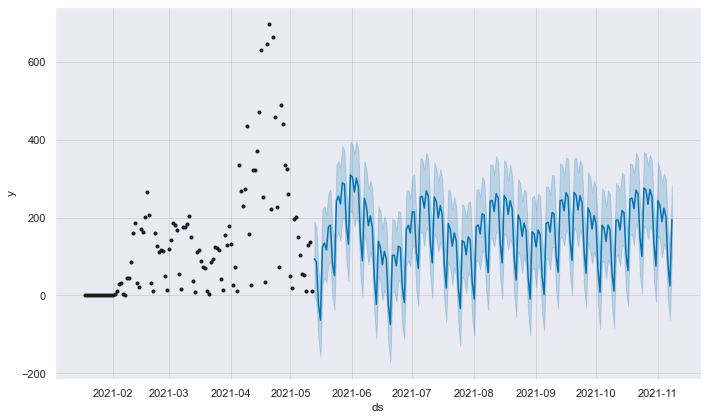

In [33]:
figl = df_prophet.plot(valores_futuro_2)

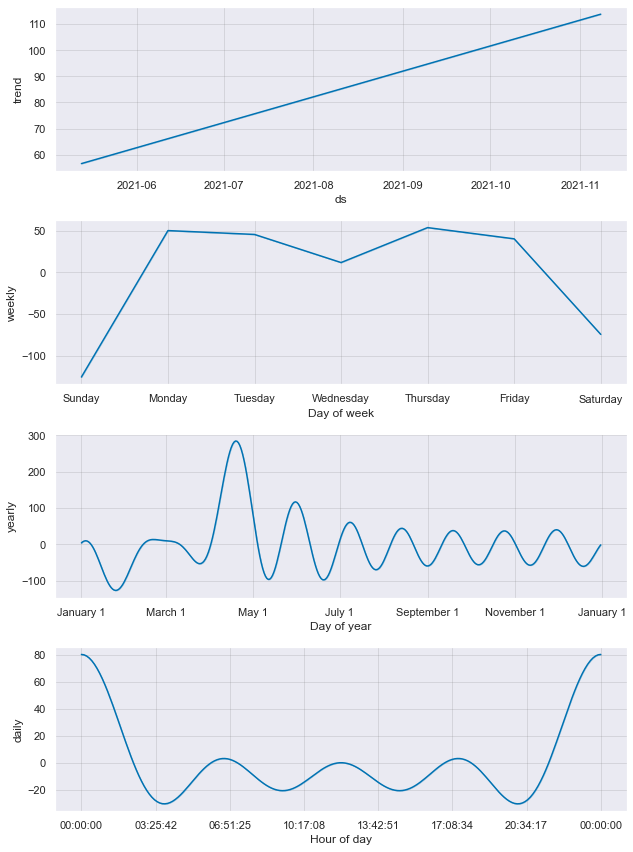

In [34]:
fig2 = df_prophet_2.plot_components(valores_futuro_2)